# Adagrad


In the optimization algorithms we introduced previously, each element of the objective function's independent variables uses the same learning rate at the same time step for self-iteration. For example, if we assume that the objective function is $f$ and the independent variable is a two-dimensional vector $[x_1, x_2]^\top$, each element in the vector uses the same learning rate when iterating. For example, in gradient descent with the learning rate $\eta$, element $x_1$ and $x_2$ both use the same learning rate $\eta$ for iteration:

$$
x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad
x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}.
$$

In :numref:`chapter_momentum`, we can see that, when there is a big difference
between the gradient values $x_1$ and $x_2$, a sufficiently small learning rate
needs to be selected so that the independent variable will not diverge in the
dimension of larger gradient values. However, this will cause the independent
variables to iterate too slowly in the dimension with smaller gradient
values. The momentum method relies on the exponentially weighted moving average
(EWMA) to make the direction of the independent variable more consistent, thus
reducing the possibility of divergence. In this section, we are going to
introduce Adagrad :cite:`Duchi.Hazan.Singer.2011`, an algorithm that adjusts the learning rate according to the
gradient value of the independent variable in each dimension to eliminate
problems caused when a unified learning rate has to adapt to all dimensions.


## The Algorithm

The Adagrad algorithm uses the cumulative variable $\boldsymbol{s}_t$ obtained from a square by element operation on the mini-batch stochastic gradient $\boldsymbol{g}_t$. At time step 0, Adagrad initializes each element in $\boldsymbol{s}_0$ to 0. At time step $t$, we first sum the results of the square by element operation for the mini-batch gradient $\boldsymbol{g}_t$ to get the variable $\boldsymbol{s}_t$:

$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$

Here, $\odot$ is the symbol for multiplication by element. Next, we re-adjust the learning rate of each element in the independent variable of the objective function using element operations:

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

Here, $\eta$ is the learning rate while $\epsilon$ is a constant added to maintain numerical stability, such as $10^{-6}$. Here, the square root, division, and multiplication operations are all element operations. Each element in the independent variable of the objective function will have its own learning rate after the operations by elements.

## Features

We should emphasize that the cumulative variable $\boldsymbol{s}_t$ produced by a square by element operation on the mini-batch stochastic gradient is part of the learning rate denominator. Therefore, if an element in the independent variable of the objective function has a constant and large partial derivative, the learning rate of this element will drop faster. On the contrary, if the partial derivative of such an element remains small, then its learning rate will decline more slowly. However, since $\boldsymbol{s}_t$ accumulates the square by element gradient, the learning rate of each element in the independent variable declines (or remains unchanged) during iteration. Therefore, when the learning rate declines very fast during early iteration, yet the current solution is still not desirable, Adagrad might have difficulty finding a useful solution because the learning rate will be too small at later stages of iteration.

Below we will continue to use the objective function $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$ as an example to observe the iterative trajectory of the independent variable in Adagrad. We are going to implement Adagrad using the same learning rate as the experiment in last section, 0.4. As we can see, the iterative trajectory of the independent variable is smoother. However, due to the cumulative effect of $\boldsymbol{s}_t$, the learning rate continuously decays, so the independent variable does not move as much during later stages of iteration.

epoch 20, x1 -2.382563, x2 -0.158591


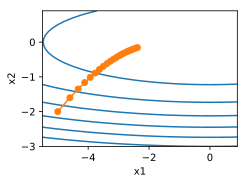

In [8]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
import math
import torch

def adagrad_2d(x1, x2, s1, s2):
    # The first two terms are the independent variable gradients
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

Now, we are going to increase the learning rate to $2$. As we can see, the independent variable approaches the optimal solution more quickly.

epoch 20, x1 -0.002295, x2 -0.000000


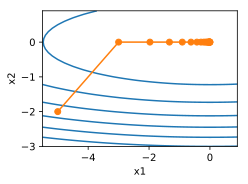

In [9]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## Implementation from Scratch

Like the momentum method, Adagrad needs to maintain a state variable of the same shape for each independent variable. We use the formula from the algorithm to implement Adagrad.

In [10]:

def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s[:] += p.grad.square()
        p[:] -= hyperparams['lr'] * p.grad / (s + eps).sqrt()

Compared with the experiment in :numref:`chapter_minibatch_sgd`, here, we use a
larger learning rate to train the model.

UnboundLocalError: local variable 'optimizer' referenced before assignment

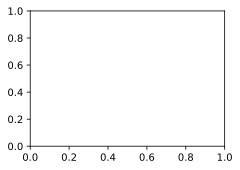

In [12]:
data_iter, feature_dim = d2l.get_data_ch10(batch_size=10)
d2l.train_ch10(torch.optim.Adagrad,{'lr': 0.1}, data_iter, feature_dim)

## Summary

* Adagrad constantly adjusts the learning rate during iteration to give each element in the independent variable of the objective function its own learning rate.
* When using Adagrad, the learning rate of each element in the independent variable decreases (or remains unchanged) during iteration.

## Exercises

* When introducing the features of Adagrad, we mentioned a potential problem. What solutions can you think of to fix this problem?
* Try to use other initial learning rates in the experiment. How does this change the results?

